In [378]:
# !pip install git+https://github.com/NVIDIAGameWorks/kaolin

In [9]:
import torch
import numpy as np
from kaolin import render,ops,io,metrics
from PIL import Image
import os

In [10]:
mesh=io.obj.import_mesh('sofa_03.obj',with_materials=False,with_normals=True)

In [11]:
# mesh.face_normals ?
# mesh.faces ?
# mesh.vertex_normals.shape
# mesh.vertices

In [12]:
vertices = mesh.vertices.unsqueeze(0).cuda()
vertex_normals= mesh.vertex_normals.unsqueeze(0).cuda()

In [13]:
faces = mesh.faces.cuda()
faces.shape

torch.Size([15924, 3])

In [14]:
look_at = (vertices.max(dim=1)[0] + vertices.min(dim=1)[0])/2.
camera_up_dir = torch.tensor([[0.,1.,0.]],device='cuda')
# lights = torch.tensor([[1.,1.,1.,1.,0.,0.,0.,0.,0.]],device='cuda')

In [15]:
camera_position = torch.tensor([[50.,0.,0.]],device='cuda')
camera_rot , camera_trans = render.camera.generate_rotate_translate_matrices(camera_position, look_at, camera_up_dir)

In [16]:
render.camera.rotate_translate_points(vertices, camera_rot, camera_trans).shape
# 3D points in new rotation, of same shape than points.

torch.Size([1, 7988, 3])

In [21]:
camera_proj = render.camera.generate_perspective_projection(60, ratio=1.0, dtype=torch.float32).cuda()# camera_proj = render.camera.camera_projection.cuda()
# camera projection matrix, of shape (3,1).

In [26]:
two_d_projection = render.camera.perspective_camera(vertices, camera_proj).cuda()
# 2D points on image plane of shape (batch_size,num_points,2).

In [29]:
render.mesh.prepare_vertices(vertices, faces, camera_rot, camera_trans, camera_proj).cuda()
'''The vertices in camera coordinate indexed by faces, of shape (batch_size,num_faces,face_size,3). 
The vertices in camera plan coordinate indexed by faces, of shape (batch_size,num_faces,face_size,2).
 The face normals, of shape (batch_size,num_faces).'''

NameError: name 'camera' is not defined

In [28]:
face_vertices_z = render.mesh.prepare_vertices(vertices, faces, camera_rot, camera_trans, camera_proj)[0][:,:,:,2]

NameError: name 'camera' is not defined

In [391]:
face_vertices_image = render.mesh.prepare_vertices(vertices, faces, camera_rot, camera_trans, camera_proj)[1]

In [392]:
face_normals_z = render.mesh.prepare_vertices(vertices, faces, camera_rot, camera_trans, camera_proj)[2][:,:,2]

In [393]:
faces.shape

torch.Size([15924, 3])

In [394]:
# ?
face_features = faces.reshape((1,faces.shape[0],3,1)).cuda().float()
'''Features (per-vertex per-face) to be drawn, of shape (batch_size,num_faces,3,feature_dim),
 feature is the features dimension, for instance with vertex colors num_features=3 (R, G, B),
 and texture coordinates num_features=2 (X, Y), or a list of num_features, of
 shapes (batch_size,num_faces,3,feature_dim[i])'''

'Features (per-vertex per-face) to be drawn, of shape (batch_size,num_faces,3,feature_dim),\n feature is the features dimension, for instance with vertex colors num_features=3 (R, G, B),\n and texture coordinates num_features=2 (X, Y), or a list of num_features, of\n shapes (batch_size,num_faces,3,feature_dim[i])'

In [395]:
rendered = render.mesh.dibr_rasterization(512, 512, face_vertices_z, face_vertices_image, face_features, face_normals_z, sigmainv=7000, boxlen=0.02, knum=30, multiplier=1000)

In [396]:
from matplotlib import pyplot as plt

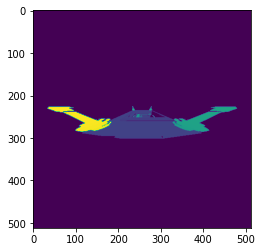

In [397]:
plt.imshow(rendered[0].squeeze(0).squeeze(2).cpu().numpy())

In [398]:
rendered

(tensor([[[[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          ...,
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]]]], device='cuda:0'), tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 